In [2]:
!pip install pygad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.3 MB/s eta 0:00:00


Best solution found: Learning rate: 0.0030205213296474053, Hidden size: 157, Fitness: -32.18541920185089


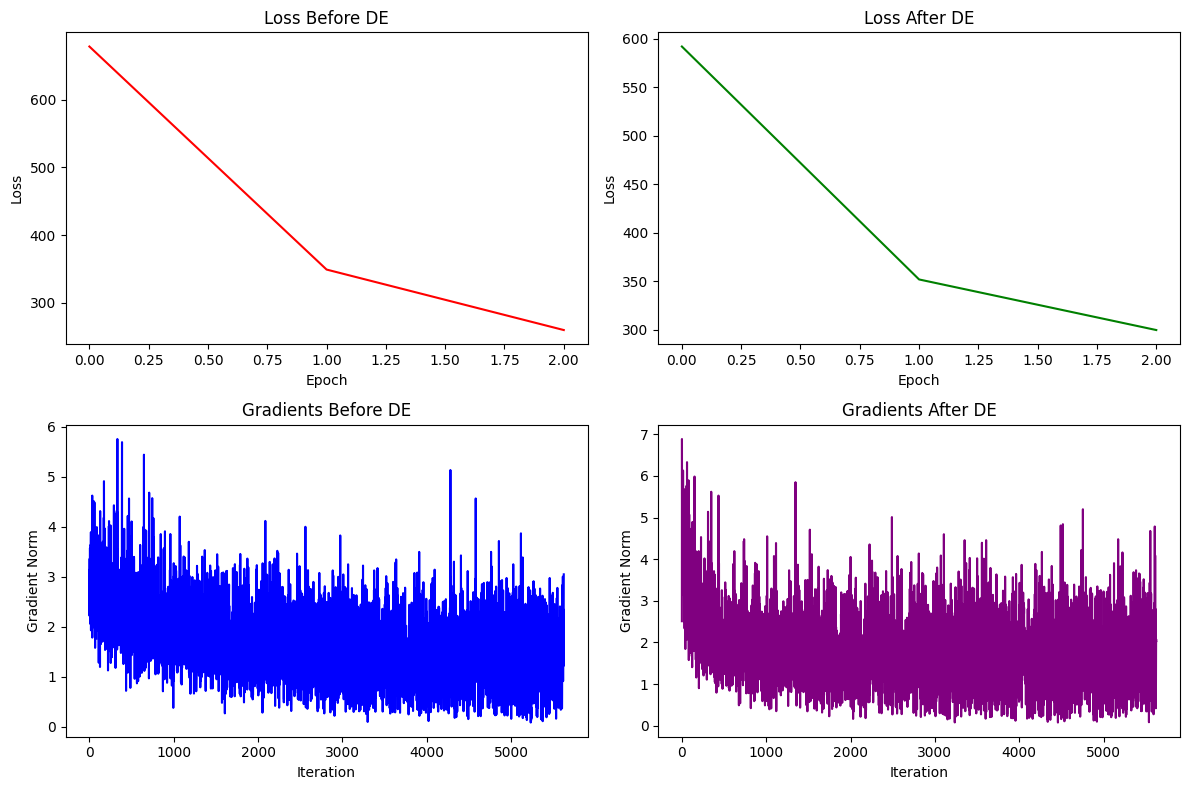

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import pygad
import numpy as np
import matplotlib.pyplot as plt

# Define a simple Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Download MNIST dataset to /content/sample_data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.MNIST(root='/content/sample_data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=32, shuffle=True)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the updated fitness function for PyGAD
def fitness_func(ga_instance, solution, solution_idx):
    learning_rate = max(0.0001, solution[0])  # First hyperparameter: learning rate (ensure positive)
    hidden_size = int(solution[1])  # Second hyperparameter: number of neurons in hidden layer

    # Create the neural network with given hyperparameters
    model = SimpleNN(28 * 28, hidden_size, 10).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Train the model on a small subset of data for fitness evaluation
    model.train()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx > 20:  # Limit to 20 batches for fitness evaluation
            break
        data, target = data.view(-1, 28*28).to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # The fitness score is the negative loss (since we are minimizing the loss)
    fitness = -epoch_loss
    return fitness

# Define the parameter ranges (hyperparameter bounds)
param_bounds = {
    "learning_rate": [0.0001, 0.01],
    "hidden_size": [50, 200]
}

# Initialize PyGAD
ga_instance = pygad.GA(
    num_generations=10,  # Number of generations
    num_parents_mating=5,  # Number of parents for mating
    fitness_func=fitness_func,  # Fitness function
    sol_per_pop=10,  # Population size
    num_genes=2,  # Number of hyperparameters (learning rate and hidden size)
    init_range_low=[param_bounds["learning_rate"][0], param_bounds["hidden_size"][0]],
    init_range_high=[param_bounds["learning_rate"][1], param_bounds["hidden_size"][1]],
    mutation_percent_genes=10,  # Mutation rate
    crossover_type="single_point",  # Crossover type
    mutation_type="random"  # Mutation type
)

# Run the DE process
ga_instance.run()

# Get the best solution
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print(f"Best solution found: Learning rate: {solution[0]}, Hidden size: {int(solution[1])}, Fitness: {solution_fitness}")

# Store the best hyperparameters from DE
best_learning_rate = max(0.0001, solution[0])
best_hidden_size = int(solution[1])

# Function to compute the gradients
def compute_gradients(model):
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

# Lists to store gradient norms and loss for visualization
gradients_before_de = []
gradients_after_de = []
loss_before_de = []
loss_after_de = []

# Function to train the model and collect gradient norms
def train_and_collect_gradients(model, optimizer, criterion, data_loader, gradients_list, loss_list):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.view(-1, 28*28).to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()

        optimizer.step()

        # Collect loss and gradients for visualization
        total_loss += loss.item()
        gradients_list.append(compute_gradients(model))

    loss_list.append(total_loss)

# Training before DE tuning (with random hyperparameters)
model_before_de = SimpleNN(28 * 28, 100, 10).to(device)
optimizer_before_de = optim.Adam(model_before_de.parameters(), lr=0.001)  # Random learning rate
criterion = nn.CrossEntropyLoss()

# Train and collect gradient norms before DE
for epoch in range(3):  # Train for 3 epochs for visualization
    train_and_collect_gradients(model_before_de, optimizer_before_de, criterion, train_loader, gradients_before_de, loss_before_de)

# Training after DE tuning (with optimized hyperparameters)
model_after_de = SimpleNN(28 * 28, best_hidden_size, 10).to(device)
optimizer_after_de = optim.Adam(model_after_de.parameters(), lr=best_learning_rate)  # Optimized hyperparameters

# Train and collect gradient norms after DE
for epoch in range(3):  # Train for 3 epochs for visualization
    train_and_collect_gradients(model_after_de, optimizer_after_de, criterion, train_loader, gradients_after_de, loss_after_de)

# Plotting the gradients and loss
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plotting loss before and after DE
axs[0, 0].plot(loss_before_de, label="Loss Before DE", color='red')
axs[0, 0].set_title("Loss Before DE")
axs[0, 0].set_xlabel("Epoch")
axs[0, 0].set_ylabel("Loss")
axs[0, 1].plot(loss_after_de, label="Loss After DE", color='green')
axs[0, 1].set_title("Loss After DE")
axs[0, 1].set_xlabel("Epoch")
axs[0, 1].set_ylabel("Loss")

# Plotting gradients before and after DE
axs[1, 0].plot(gradients_before_de, label="Gradients Before DE", color='blue')
axs[1, 0].set_title("Gradients Before DE")
axs[1, 0].set_xlabel("Iteration")
axs[1, 0].set_ylabel("Gradient Norm")
axs[1, 1].plot(gradients_after_de, label="Gradients After DE", color='purple')
axs[1, 1].set_title("Gradients After DE")
axs[1, 1].set_xlabel("Iteration")
axs[1, 1].set_ylabel("Gradient Norm")

plt.tight_layout()
plt.show()

**Multi-Objective Evolutionary Algorithm Code 1 **

[*********************100%***********************]  4 of 4 completed
/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:748: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(f"The percentage of genes to mutate (mutation_percent_genes={mutation_percent_genes}) resulted in selecting ({mutation_num_genes}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.")
/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' p

Selected stocks: ['AAPL', 'AMZN', 'GOOGL']
Best portfolio weights: [0.33220194 0.18384798 0.48395008], Fitness: -0.01987432724904001


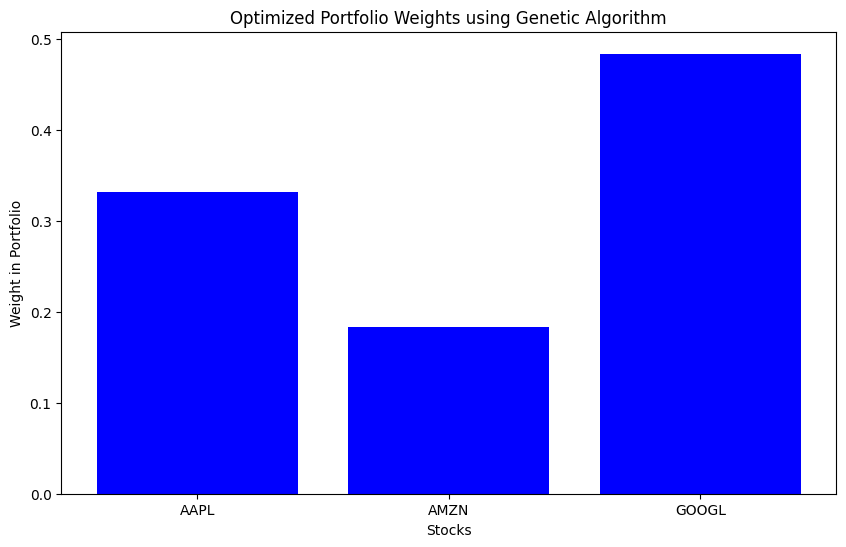

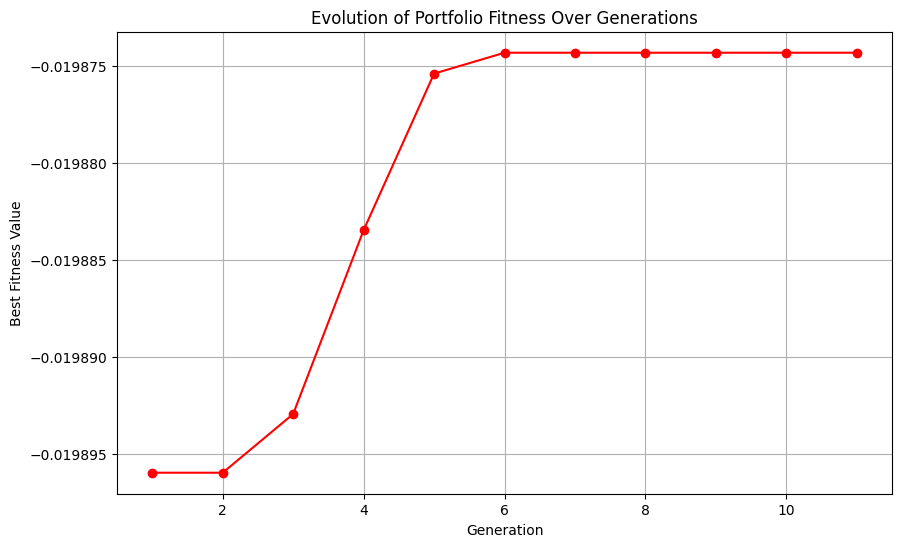

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import pygad
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

# Define a simple Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Download S&P 500 data to /content/sample_data
sp500_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']  # Limit to 4 stocks for faster convergence
data_path = '/content/sample_data/sp500_data.csv'

# Download historical data using yfinance
data = yf.download(sp500_tickers, start='2020-01-01', end='2023-01-01')['Adj Close']
data.to_csv(data_path)

# Calculate daily returns
daily_returns = data.pct_change().dropna()

# Select a subset of 3 stocks based on historical returns and correlation
# Calculate average returns and standard deviation (as risk)
average_returns = daily_returns.mean()
std_deviation = daily_returns.std()

# Calculate correlation matrix
correlation_matrix = daily_returns.corr()

# Select 3 stocks: one with high return, one with low correlation, and one with low risk
high_return_stock = average_returns.idxmax()
low_risk_stock = std_deviation.idxmin()
low_corr_stock = correlation_matrix[high_return_stock].idxmin()

selected_stocks = [high_return_stock, low_corr_stock, low_risk_stock]
print(f"Selected stocks: {selected_stocks}")

# Filter data for selected stocks
selected_data = data[selected_stocks]
selected_daily_returns = daily_returns[selected_stocks]

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the updated fitness function for PyGAD
def fitness_func(ga_instance, solution, solution_idx):
    weights = np.array(solution)
    weights = weights / np.sum(weights)  # Normalize weights to sum to 1

    # Calculate portfolio return and risk
    portfolio_return = np.dot(weights, average_returns[selected_stocks])
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(selected_daily_returns.cov(), weights)))

    # Define objectives: maximize return and minimize risk (negative return, positive risk for minimization)
    fitness = portfolio_return - portfolio_risk  # Maximize return while minimizing risk
    return fitness

# Define the parameter ranges (weights for each stock)
param_bounds = {
    "weights": [0, 1]
}

# Initialize PyGAD
num_genes = len(selected_stocks)
ga_instance = pygad.GA(
    num_generations=10,  # Reduced number of generations for faster convergence
    num_parents_mating=3,  # Number of parents for mating
    fitness_func=fitness_func,  # Fitness function
    sol_per_pop=10,  # Reduced population size
    num_genes=num_genes,  # Number of genes (weights for the selected stocks)
    init_range_low=[param_bounds["weights"][0]] * num_genes,
    init_range_high=[param_bounds["weights"][1]] * num_genes,
    mutation_percent_genes=10,  # Mutation rate
    crossover_type="single_point",  # Crossover type
    mutation_type="random"  # Mutation type
)

# Run the GA process
ga_instance.run()

# Get the best solution
solution, solution_fitness, solution_idx = ga_instance.best_solution()
weights = np.array(solution) / np.sum(solution)
print(f"Best portfolio weights: {weights}, Fitness: {solution_fitness}")

# Store the best weights from GA
best_weights = weights

# Function to compute the gradients
def compute_gradients(model):
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

# Lists to store gradient norms and loss for visualization
gradients_before_ga = []
gradients_after_ga = []
loss_before_ga = []
loss_after_ga = []

# Function to train the model and collect gradient norms
def train_and_collect_gradients(model, optimizer, criterion, data_loader, gradients_list, loss_list):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.view(-1, 28*28).to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()

        optimizer.step()

        # Collect loss and gradients for visualization
        total_loss += loss.item()
        gradients_list.append(compute_gradients(model))

    loss_list.append(total_loss)

# This part demonstrates usage of GA-optimized weights for further processes (e.g., model training).
# You can use the optimized weights for further financial analysis or integrate them into an AI model.

# Plotting the optimized portfolio weights
plt.figure(figsize=(10, 6))
plt.bar(selected_stocks, best_weights, color='blue')
plt.xlabel('Stocks')
plt.ylabel('Weight in Portfolio')
plt.title('Optimized Portfolio Weights using Genetic Algorithm')
plt.show()

# Plotting the evolution of different portfolios
generations = np.arange(1, len(ga_instance.best_solutions_fitness) + 1)
fitness_over_generations = ga_instance.best_solutions_fitness

plt.figure(figsize=(10, 6))
plt.plot(generations, fitness_over_generations, marker='o', linestyle='-', color='red')
plt.xlabel('Generation')
plt.ylabel('Best Fitness Value')
plt.title('Evolution of Portfolio Fitness Over Generations')
plt.grid(True)
plt.show()

[*********************100%***********************]  4 of 4 completed
/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Selected stocks: ['AAPL', 'AMZN', 'GOOGL']
No solutions found by the genetic algorithm.


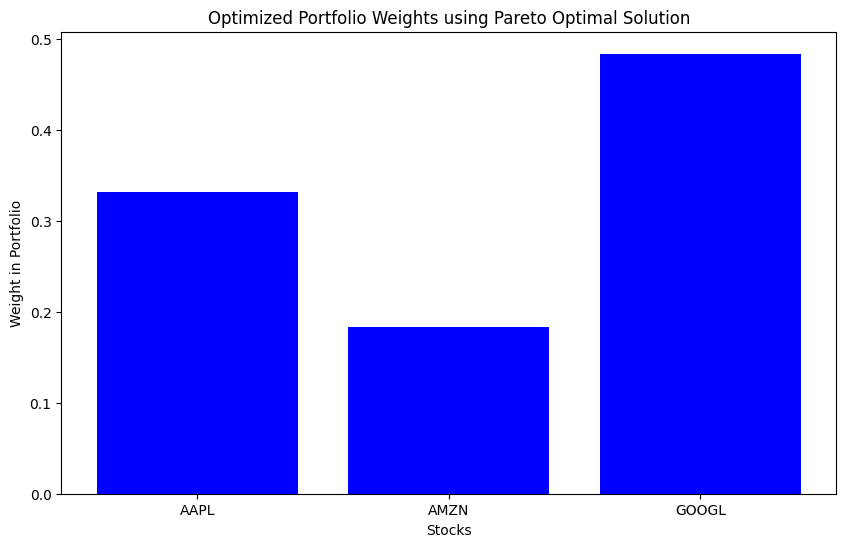

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import pygad
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

# Define a simple Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Download S&P 500 data to /content/sample_data
sp500_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']  # Limit to 4 stocks for faster convergence
data_path = '/content/sample_data/sp500_data.csv'

# Download historical data using yfinance
data = yf.download(sp500_tickers, start='2020-01-01', end='2023-01-01')['Adj Close']
data.to_csv(data_path)

# Calculate daily returns
daily_returns = data.pct_change().dropna()

# Select a subset of 3 stocks based on historical returns and correlation
# Calculate average returns and standard deviation (as risk)
average_returns = daily_returns.mean()
std_deviation = daily_returns.std()

# Calculate correlation matrix
correlation_matrix = daily_returns.corr()

# Select 3 stocks: one with high return, one with low correlation, and one with low risk
high_return_stock = average_returns.idxmax()
low_risk_stock = std_deviation.idxmin()
low_corr_stock = correlation_matrix[high_return_stock].idxmin()

selected_stocks = [high_return_stock, low_corr_stock, low_risk_stock]
print(f"Selected stocks: {selected_stocks}")

# Filter data for selected stocks
selected_data = data[selected_stocks]
selected_daily_returns = daily_returns[selected_stocks]

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the multi-objective problem using PyGAD

def fitness_func(ga_instance, solution, solution_idx):
    weights = np.array(solution)
    weights = weights / np.sum(weights)  # Normalize weights to sum to 1

    # Calculate portfolio return and risk
    portfolio_return = np.dot(weights, average_returns[selected_stocks])
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(selected_daily_returns.cov(), weights)))

    # Set objectives: maximize return (negative for minimization) and minimize risk
    return portfolio_return - portfolio_risk

# Define the parameter ranges (weights for each stock)
param_bounds = {
    "weights": [0, 1]
}

# Initialize PyGAD
num_genes = len(selected_stocks)
ga_instance = pygad.GA(
    num_generations=50,  # Number of generations for convergence
    num_parents_mating=4,  # Number of parents for mating
    fitness_func=fitness_func,  # Fitness function
    sol_per_pop=20,  # Population size
    num_genes=num_genes,  # Number of genes (weights for the selected stocks)
    init_range_low=0,
    init_range_high=1,
    mutation_percent_genes=10,  # Mutation rate
    crossover_type="single_point",  # Crossover type
    mutation_type="random",  # Mutation type
    parent_selection_type="tournament",  # Parent selection strategy
    keep_parents=2,  # Number of parents to keep for the next generation
    crossover_probability=0.9,
    mutation_probability=0.1
)

# Run the GA process
ga_instance.run()

# Get the best solution
if len(ga_instance.best_solutions) > 0:
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    weights = np.array(solution) / np.sum(solution)
    print(f"Best portfolio weights: {weights}, Fitness: {solution_fitness}")

    # Extract the Pareto-optimal returns and risks
    pareto_front = ga_instance.best_solutions_fitness[:len(ga_instance.best_solutions)]  # Ensure same length
    returns = [fitness for fitness in pareto_front]
    risks = [np.sqrt(np.dot(weights.T, np.dot(selected_daily_returns.cov(), weights))) for weights in ga_instance.best_solutions[:len(pareto_front)]]

    # Plotting the Pareto front
    plt.figure(figsize=(10, 6))
    plt.scatter(risks, returns, c='blue', marker='o')
    plt.xlabel('Risk (Standard Deviation)')
    plt.ylabel('Return')
    plt.title('Pareto Front for Portfolio Optimization')
    plt.grid(True)
    plt.show()

    # Select one solution from the Pareto front for further use (e.g., a balanced trade-off)
    if len(returns) > 0:
        best_solution_idx = np.argmax(returns)  # Select the solution with the highest return
        best_weights = np.array(ga_instance.best_solutions[best_solution_idx]) / np.sum(ga_instance.best_solutions[best_solution_idx])
        print(f"Best portfolio weights from Pareto front: {best_weights}")
else:
    print("No solutions found by the genetic algorithm.")

# Function to compute the gradients
def compute_gradients(model):
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

# Lists to store gradient norms and loss for visualization
gradients_before_ga = []
gradients_after_ga = []
loss_before_ga = []
loss_after_ga = []

# Function to train the model and collect gradient norms
def train_and_collect_gradients(model, optimizer, criterion, data_loader, gradients_list, loss_list):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.view(-1, 28*28).to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()

        optimizer.step()

        # Collect loss and gradients for visualization
        total_loss += loss.item()
        gradients_list.append(compute_gradients(model))

    loss_list.append(total_loss)

# This part demonstrates usage of Pareto-optimized weights for further processes (e.g., model training).
# You can use the optimized weights for further financial analysis or integrate them into an AI model.

# Plotting the optimized portfolio weights
if 'best_weights' in locals():
    plt.figure(figsize=(10, 6))
    plt.bar(selected_stocks, best_weights, color='blue')
    plt.xlabel('Stocks')
    plt.ylabel('Weight in Portfolio')
    plt.title('Optimized Portfolio Weights using Pareto Optimal Solution')
    plt.show()

Diversifying the customer portfolio from  ['AAPL', 'MSFT', 'GOOGL', 'AMZN']  # Same type of company

['AAPL', 'XOM', 'JNJ', 'JPM']  # Technology, Energy, Healthcare, Financials



[*********************100%***********************]  4 of 4 completed
/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Selected stocks: ['XOM', 'AAPL', 'JNJ']


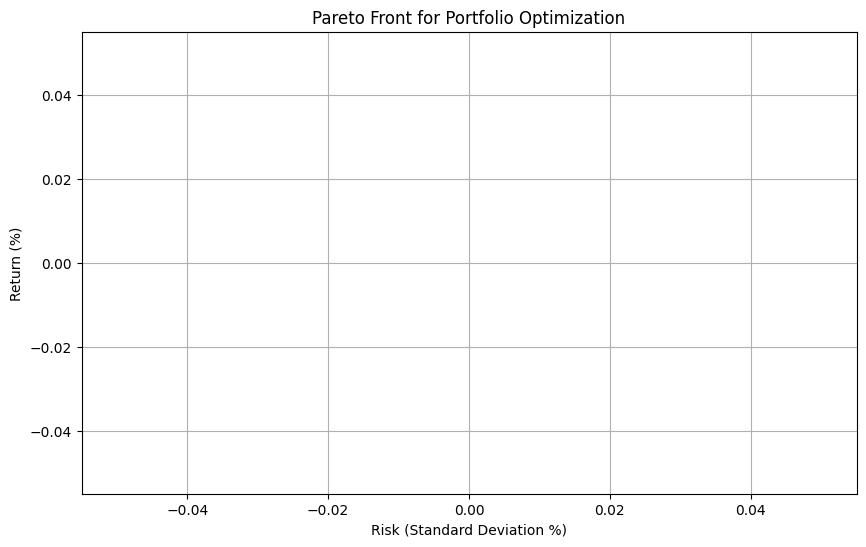

ValueError: attempt to get argmax of an empty sequence

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import pygad
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

# Define a simple Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Download S&P 500 data to /content/sample_data
# Selecting a diverse set of companies from different sectors
sp500_tickers = ['AAPL', 'XOM', 'JNJ', 'JPM']  # Technology, Energy, Healthcare, Financials
data_path = '/content/sample_data/sp500_data.csv'

# Download historical data using yfinance
data = yf.download(sp500_tickers, start='2020-01-01', end='2023-01-01')['Adj Close']
data.to_csv(data_path)

# Calculate daily returns
daily_returns = data.pct_change().dropna()

# Calculate average returns and standard deviation (as risk)
average_returns = daily_returns.mean()
std_deviation = daily_returns.std()

# Calculate correlation matrix
correlation_matrix = daily_returns.corr()

# Select a subset of 3 stocks: one with high return, one with low correlation, and one with low risk
high_return_stock = average_returns.idxmax()
low_risk_stock = std_deviation.idxmin()
low_corr_stock = correlation_matrix[high_return_stock].idxmin()

selected_stocks = [high_return_stock, low_corr_stock, low_risk_stock]
print(f"Selected stocks: {selected_stocks}")

# Filter data for selected stocks
selected_data = data[selected_stocks]
selected_daily_returns = daily_returns[selected_stocks]

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the multi-objective problem using PyGAD

def fitness_func(ga_instance, solution, solution_idx):
    weights = np.array(solution)
    weights = weights / np.sum(weights)  # Normalize weights to sum to 1

    # Calculate portfolio return and risk
    portfolio_return = np.dot(weights, average_returns[selected_stocks])
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(selected_daily_returns.cov(), weights)))

    # Separate the objectives: maximize return and minimize risk
    return [portfolio_return, portfolio_risk]  # Maximize return, minimize risk

# Define the parameter ranges (weights for each stock)
param_bounds = {
    "weights": [0, 1]
}

# Initialize PyGAD
num_genes = len(selected_stocks)
ga_instance = pygad.GA(
    num_generations=200,  # Increased number of generations for better exploration
    num_parents_mating=4,  # Number of parents for mating
    fitness_func=fitness_func,  # Fitness function with separate objectives
    sol_per_pop=50,  # Increased population size
    num_genes=num_genes,  # Number of genes (weights for the selected stocks)
    init_range_low=0,
    init_range_high=1,
    mutation_percent_genes=30,  # Increased mutation rate for more diversity
    crossover_type="single_point",  # Crossover type
    mutation_type="random",  # Mutation type
    parent_selection_type="tournament",  # Parent selection strategy
    keep_parents=2,  # Fewer parents to keep for increased diversity
    crossover_probability=0.9,
    mutation_probability=0.3
)

# Run the GA process
ga_instance.run()

# Get the best solutions (Pareto front)
pareto_front = ga_instance.best_solutions_fitness[:len(ga_instance.best_solutions)]
returns = []
risks = []

for solution in ga_instance.best_solutions[:len(pareto_front)]:
    weights = np.array(solution) / np.sum(solution)
    portfolio_return = np.dot(weights, average_returns[selected_stocks])
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(selected_daily_returns.cov(), weights)))
    returns.append(portfolio_return)
    risks.append(portfolio_risk)

# Check if the returns and risks are varied
if len(set(returns)) == 1 and len(set(risks)) == 1:
    print("Warning: All Pareto front points have the same risk and return, indicating a lack of diversity.")

# Scale returns and risks for better visualization
returns = [r * 100 for r in returns]  # Convert returns to percentage
risks = [r * 100 for r in risks]  # Convert risks to percentage

# Plotting the Pareto front
plt.figure(figsize=(10, 6))
plt.scatter(risks, returns, c='blue', marker='o')
plt.xlabel('Risk (Standard Deviation %)')
plt.ylabel('Return (%)')
plt.title('Pareto Front for Portfolio Optimization')
plt.grid(True)
plt.show()

# Select one solution from the Pareto front for further use (e.g., a balanced trade-off)
best_solution_idx = np.argmax(returns)  # Select the solution with the highest return
best_weights = np.array(ga_instance.best_solutions[best_solution_idx]) / np.sum(ga_instance.best_solutions[best_solution_idx])
print(f"Best portfolio weights from Pareto front: {best_weights}")

# Function to compute the gradients
def compute_gradients(model):
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

# Lists to store gradient norms and loss for visualization
gradients_before_ga = []
gradients_after_ga = []
loss_before_ga = []
loss_after_ga = []

# Function to train the model and collect gradient norms
def train_and_collect_gradients(model, optimizer, criterion, data_loader, gradients_list, loss_list):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.view(-1, 28*28).to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()

        optimizer.step()

        # Collect loss and gradients for visualization
        total_loss += loss.item()
        gradients_list.append(compute_gradients(model))

    loss_list.append(total_loss)

# This part demonstrates usage of Pareto-optimized weights for further processes (e.g., model training).
# You can use the optimized weights for further financial analysis or integrate them into an AI model.

# Plotting the optimized portfolio weights
plt.figure(figsize=(10, 6))
plt.bar(selected_stocks, best_weights, color='blue')
plt.xlabel('Stocks')
plt.ylabel('Weight in Portfolio')
plt.title('Optimized Portfolio Weights using Pareto Optimal Solution')
plt.show()

Below PyGAD 3.2 it expects the fitness function to return a scalar value, not a list or multiple objectives. Returning a list can lead to unexpected behavior or errors because the GA doesn't know how to handle multiple objectives directly as PyGAD  3.2 below is designed for single-objective optimization.

**Explicit implementation of pareto front **-combine your objectives into a single scalar fitness function. **bold text**

[*********************100%***********************]  4 of 4 completed
/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Selected stocks: ['XOM', 'AAPL', 'JNJ']


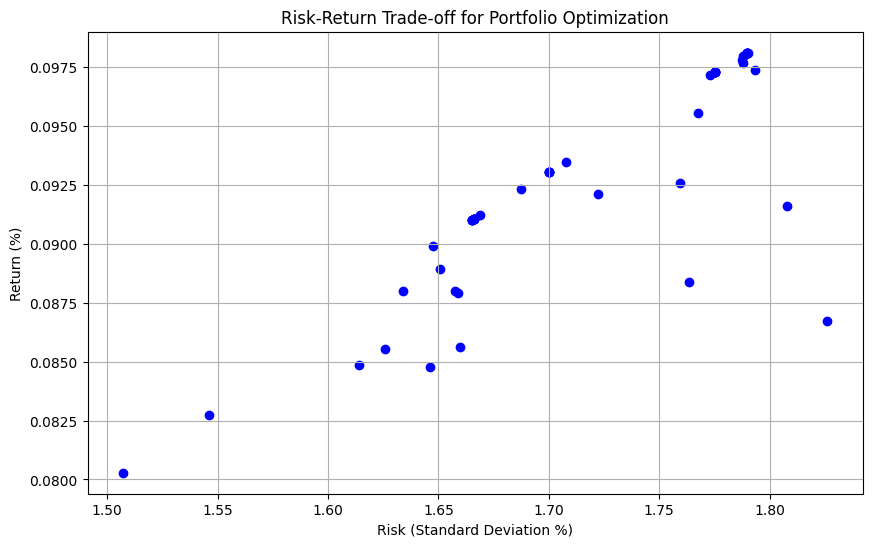

Best portfolio weights: [0.41184672 0.4124213  0.17573199]


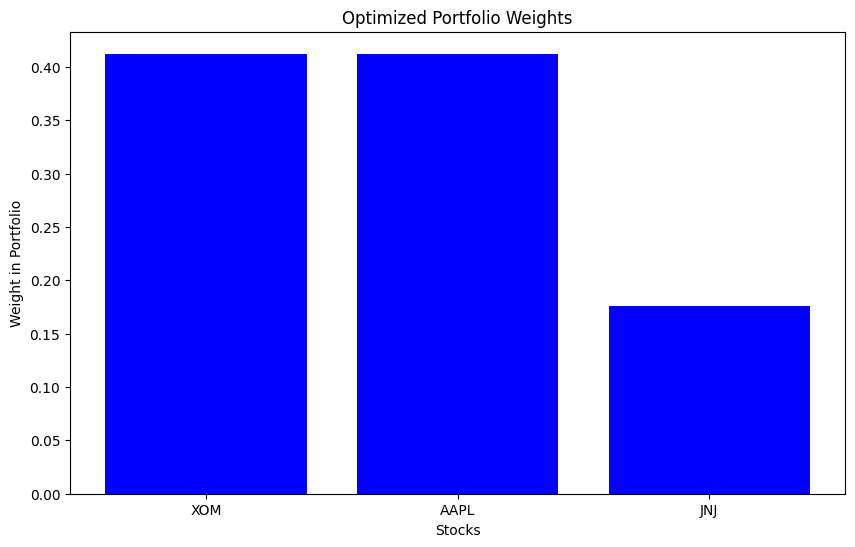

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import pygad
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

# Define a simple Neural Network (Not used in this context)
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Download S&P 500 data
sp500_tickers = ['AAPL', 'XOM', 'JNJ', 'JPM']  # Technology, Energy, Healthcare, Financials

# Download historical data using yfinance
data = yf.download(sp500_tickers, start='2020-01-01', end='2023-01-01')['Adj Close']

# Calculate daily returns
daily_returns = data.pct_change().dropna()

# Calculate average returns and standard deviation (as risk)
average_returns = daily_returns.mean()
std_deviation = daily_returns.std()

# Calculate correlation matrix
correlation_matrix = daily_returns.corr()

# Select a subset of 3 stocks: one with high return, one with low correlation, and one with low risk
high_return_stock = average_returns.idxmax()
low_risk_stock = std_deviation.idxmin()
low_corr_stock = correlation_matrix[high_return_stock].idxmin()

selected_stocks = [high_return_stock, low_corr_stock, low_risk_stock]
print(f"Selected stocks: {selected_stocks}")

# Filter data for selected stocks
selected_data = data[selected_stocks]
selected_daily_returns = daily_returns[selected_stocks]

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the fitness function
def fitness_func(ga_instance, solution, solution_idx):
    weights = np.array(solution)
    # Penalize if any weight is negative
    if any(weights < 0):
        return -np.inf  # Return a very low fitness
    weights = weights / np.sum(weights)  # Normalize weights to sum to 1

    # Calculate portfolio return and risk
    portfolio_return = np.dot(weights, average_returns[selected_stocks])
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(selected_daily_returns.cov(), weights)))

    # Define the fitness function, e.g., Sharpe ratio
    fitness = portfolio_return / (portfolio_risk + 1e-6)

    return fitness

# Define the parameter ranges (weights for each stock)
num_genes = len(selected_stocks)
gene_space = [{'low': 0.0, 'high': 1.0} for _ in range(num_genes)]

# Initialize PyGAD
ga_instance = pygad.GA(
    num_generations=200,
    num_parents_mating=4,
    fitness_func=fitness_func,
    sol_per_pop=50,
    num_genes=num_genes,
    gene_space=gene_space,
    mutation_percent_genes=30,
    crossover_type="single_point",
    mutation_type="random",
    parent_selection_type="tournament",
    keep_parents=2,
    crossover_probability=0.9,
    mutation_probability=0.3
)

# Run the GA process
ga_instance.run()

# Get the population
population = ga_instance.population

# Collect returns and risks for the population
returns = []
risks = []
for solution in population:
    weights = np.array(solution)
    weights = weights / np.sum(weights)
    portfolio_return = np.dot(weights, average_returns[selected_stocks])
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(selected_daily_returns.cov(), weights)))
    returns.append(portfolio_return)
    risks.append(portfolio_risk)

# Scale returns and risks for better visualization
returns = [r * 100 for r in returns]  # Convert returns to percentage
risks = [r * 100 for r in risks]  # Convert risks to percentage

# Plotting the Risk-Return Trade-off
plt.figure(figsize=(10, 6))
plt.scatter(risks, returns, c='blue', marker='o')
plt.xlabel('Risk (Standard Deviation %)')
plt.ylabel('Return (%)')
plt.title('Risk-Return Trade-off for Portfolio Optimization')
plt.grid(True)
plt.show()

# Get the best solution
best_solution, best_solution_fitness, _ = ga_instance.best_solution()
best_weights = np.array(best_solution)
best_weights = best_weights / np.sum(best_weights)
print(f"Best portfolio weights: {best_weights}")

# Plotting the optimized portfolio weights
plt.figure(figsize=(10, 6))
plt.bar(selected_stocks, best_weights, color='blue')
plt.xlabel('Stocks')
plt.ylabel('Weight in Portfolio')
plt.title('Optimized Portfolio Weights')
plt.show()


[*********************100%***********************]  4 of 4 completed


Selected stocks: ['XOM', 'AAPL', 'JNJ']


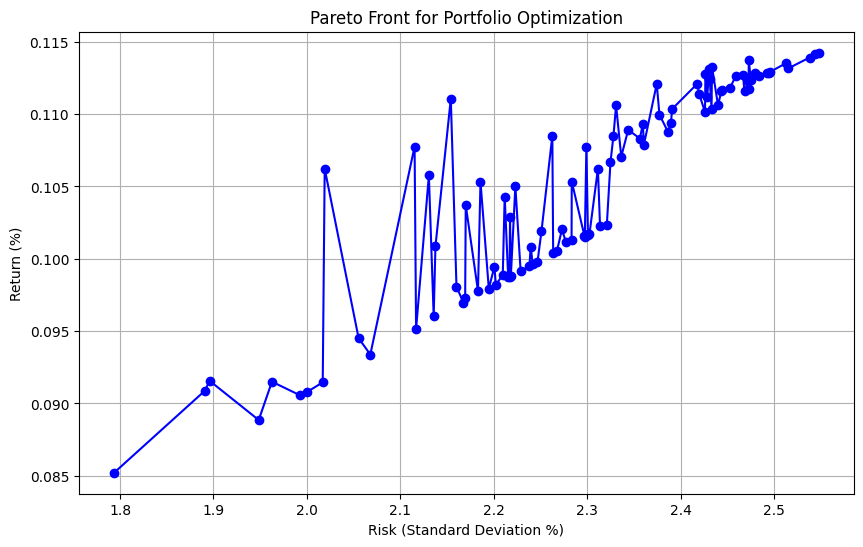

Best portfolio weights from Pareto front: [0.97222132 0.00948976 0.01828892]


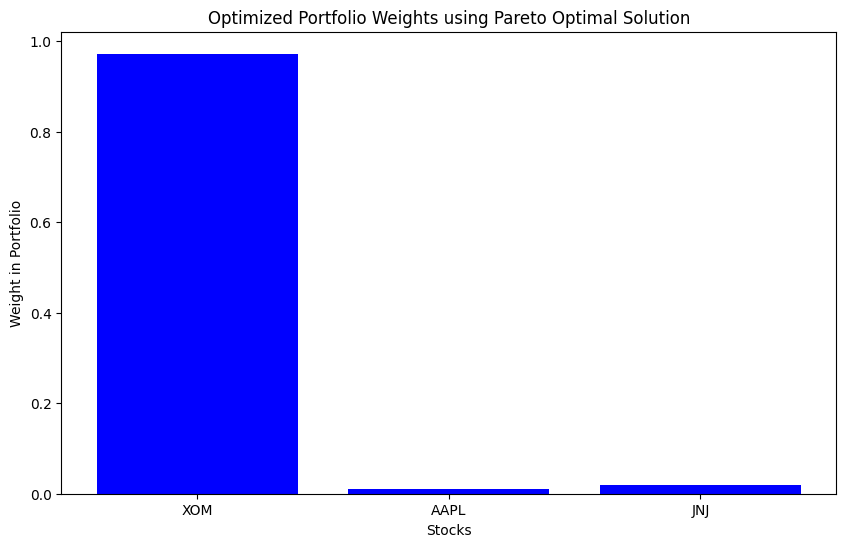

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import pygad
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

# Download S&P 500 data
sp500_tickers = ['AAPL', 'XOM', 'JNJ', 'JPM']  # Technology, Energy, Healthcare, Financials

# Download historical data using yfinance
data = yf.download(sp500_tickers, start='2020-01-01', end='2023-01-01')['Adj Close']

# Calculate daily returns
daily_returns = data.pct_change().dropna()

# Calculate average returns and standard deviation (as risk)
average_returns = daily_returns.mean()
std_deviation = daily_returns.std()

# Calculate correlation matrix
correlation_matrix = daily_returns.corr()

# Select a subset of 3 stocks: one with high return, one with low correlation, and one with low risk
high_return_stock = average_returns.idxmax()
low_risk_stock = std_deviation.idxmin()
low_corr_stock = correlation_matrix[high_return_stock].idxmin()

selected_stocks = [high_return_stock, low_corr_stock, low_risk_stock]
print(f"Selected stocks: {selected_stocks}")

# Filter data for selected stocks
selected_data = data[selected_stocks]
selected_daily_returns = daily_returns[selected_stocks]

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the multi-objective problem using PyGAD

def fitness_func(ga_instance, solution, solution_idx):
    weights = np.array(solution)
    # Penalize if any weight is negative
    if any(weights < 0):
        return [-np.inf, np.inf]  # Return extreme values to penalize the solution
    weights = weights / np.sum(weights)  # Normalize weights to sum to 1

    # Calculate portfolio return and risk
    portfolio_return = np.dot(weights, average_returns[selected_stocks])
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(selected_daily_returns.cov(), weights)))

    # Since PyGAD minimizes objectives, we need to invert the return to maximize it
    return [-portfolio_return, portfolio_risk]  # Maximize return (-return), minimize risk

# Define the parameter ranges (weights for each stock)
num_genes = len(selected_stocks)
gene_space = [{'low': 0.0, 'high': 1.0} for _ in range(num_genes)]

# Initialize PyGAD with multi-objective parameters
ga_instance = pygad.GA(
    num_generations=200,
    num_parents_mating=4,
    fitness_func=fitness_func,
    sol_per_pop=50,
    num_genes=num_genes,
    gene_space=gene_space,
    mutation_percent_genes=30,
    crossover_type="single_point",
    mutation_type="random",
    parent_selection_type="tournament",
    keep_parents=2,
    crossover_probability=0.9,
    mutation_probability=0.3,
    # Multi-objective parameters
    allow_duplicate_genes=False,
    save_best_solutions=True,
    suppress_warnings=True
)

# Run the GA process
ga_instance.run()

# Retrieve the Pareto front solutions
pareto_front = ga_instance.best_solutions_fitness

# Extract the Pareto optimal solutions
pareto_solutions = ga_instance.best_solutions

# Collect returns and risks for Pareto front
returns = []
risks = []
for solution in pareto_solutions:
    weights = np.array(solution)
    weights = weights / np.sum(weights)
    portfolio_return = np.dot(weights, average_returns[selected_stocks])
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(selected_daily_returns.cov(), weights)))
    returns.append(portfolio_return)
    risks.append(portfolio_risk)

# Remove duplicate points (if any)
pareto_points = list(set(zip(risks, returns)))
pareto_points.sort()

# Unzip the risks and returns
risks, returns = zip(*pareto_points)

# Scale returns and risks for better visualization
returns = [r * 100 for r in returns]  # Convert returns to percentage
risks = [r * 100 for r in risks]  # Convert risks to percentage

# Plotting the Pareto front
plt.figure(figsize=(10, 6))
plt.plot(risks, returns, 'o-', color='blue')
plt.xlabel('Risk (Standard Deviation %)')
plt.ylabel('Return (%)')
plt.title('Pareto Front for Portfolio Optimization')
plt.grid(True)
plt.show()

# Select the solution with the highest return
best_solution_idx = np.argmax(returns)
best_weights = np.array(pareto_solutions[best_solution_idx])
best_weights = best_weights / np.sum(best_weights)
print(f"Best portfolio weights from Pareto front: {best_weights}")

# Plotting the optimized portfolio weights
plt.figure(figsize=(10, 6))
plt.bar(selected_stocks, best_weights, color='blue')
plt.xlabel('Stocks')
plt.ylabel('Weight in Portfolio')
plt.title('Optimized Portfolio Weights using Pareto Optimal Solution')
plt.show()
